# Graph Partition

https://en.wikipedia.org/wiki/Graph_partition

The problem is to part a graph into two graph which have equal number of vertexes, so that the number of edges connecting the two graph is minimized.

To map this problem to an Ising System, we first think about how will we connect the solution of the problem to the output of an Ising System. For a Ising System or a quantum annealer, the output is the measurements of each spin, which can be +1 or -1. For this problem, the solution is two set of vertexes, each corresponding to sub-graph. So a natural way is to associate each vertex to a spin. Then our goal is to have measurements have equal number of +1 and -1, while minimize the connection between +1 and -1 which derived from the original graph.

So we can design a energy function that assign penalty for any configurations that deviate from our goal.

More specifically, we assign a penalty for not having equal number of +1 and -1 in the following way
$$E_1=A(\sum_i s_i)^2$$
where $A>0$ is the parameter to control the penalty.

We also assign a penalty for having edges between +1 and -1 in the following way
$$E_2=B\sum_{i,j\in E}(1-s_i s_j)$$
where $B>0$ is the parameter to control the penalty.

So the total energy function we want to minimize is
$$H = \frac{A}{2}(\sum_i s_i)^2 + \frac{B}{2}\sum_{(i,j)\in E}(1-s_i s_j)$$

Expand the total energy function, we got
$$H = A \sum_{i< j}s_i s_j + B\sum_{i< j \text{ and } (i,j)\in E}(1-s_i s_j)$$

On the other hand, an classical Ising is described by the Hamiltonian
$$H = \sum_{ij}J_{ij}s_i s_j + \sum_i h_i s_i$$

So we can build an Ising system that, the coupling between two spin $i$ and $j$ is $A$ if no edge connecting $i$,$j$, is $A-B$ if there is an edge connecting $i$,$j$, and apply no bias. 

The value of $A$ and $B$ is chosen so that the penalty of voilating equal number of +1 and -1 is always larger than the energy gain of reduing number of cuts, i.e.
$$2A\ge B\min\{\Delta(G),n/2\}$$

In [128]:
import isakov_wrapper2 as qxb
import math

import networkx as nx
from networkx.drawing.nx_pydot import write_dot
import metis
from graphviz import Source

import IPython

In [137]:
def part_on_isakov(graph, plot_result=False):
    '''graph partition by quantum algorithm using isakov simulator
    :param graph: The graph specified in a list of tuples, 
                  each tuple contain the two endpoints of an edge
    :return: number of edges cuts  
    '''
    n_vertexes = apply(max,map(max,graph)) + 1
    assert n_vertexes>0 and n_vertexes%2 == 0
    G = nx.Graph()
    G.add_edges_from(graph)
    max_deg = max(dict(nx.degree(G)).values())
    
    B = 100.
    A = math.ceil(B*min(2*max_deg, n_vertexes)/4.)
    coff_mat = {}
    for i in range(n_vertexes):
        for j in range(i+1, n_vertexes):
            if (i,j) in graph or (j,i) in graph:
                coff_mat[(i,j)] = A - B
            else:
                coff_mat[(i,j)] = A
    #coff_mat[(0,0)] = 10000
    outcomes = qxb.solve_on_isakov(coff_mat, n_sweeps=500, n_reads=20000)
    gauge_fixed_outcomes = [outcome for outcome in outcomes if outcome.solution[0]==0]
    min_energy_outcomes = gauge_fixed_outcomes #[outcome for outcome in gauge_fixed_outcomes if outcome.energy==outcomes[0].energy]
    #print outcomes
    occur = 0
    parts = None
    for min_energy_outcome in min_energy_outcomes:
        if min_energy_outcome.occurrences > occur:
            occur = min_energy_outcome.occurrences
            parts = min_energy_outcome.solution
    
    # plot the result graph
    colors = ['green','purple']
    n_cuts = 0
    for i, p in enumerate(parts):
        G.node[i]['color'] = colors[p]
        for j in G.neighbors(i):
            if i<j and parts[i] != parts[j]:
                n_cuts += 1
    write_dot(G, 'quantum_by_metis.dot')     # Requires pydot or pygraphviz
    if plot_result:
        IPython.display.display(Source.from_file('quantum_by_metis.dot'))
    return n_cuts

In [130]:
def part_on_metis(graph, plot_result=False):
    '''graph partition by classic algorithm using metis
    :param graph: The graph specified in a list of tuples, 
                  each tuple contain the two endpoints of an edge
    :return: number of edgecuts
    '''
    G = nx.Graph()
    G.add_edges_from(graph)    
    (edgecuts, parts) = metis.part_graph(G, nparts=2, objtype='cut')
    colors = ['red','blue']
    for i, p in enumerate(parts):
         G.node[i]['color'] = colors[p]
    write_dot(G, 'classic_by_metis.dot')     # Requires pydot or pygraphviz
    if plot_result:
        IPython.display.display(Source.from_file('classic_by_metis.dot'))
    return edgecuts

In [131]:
def test():
    test_graphs = [
    [(0,1),(1,3),(2,0)],
    [(0, 8), (0, 1), (0, 2), (0, 4), (1, 2), (1, 3), (1, 4), (1, 7), (1, 8), (1, 9), (2, 3), (2, 4), (2, 6), (3, 6), (3, 7), (4, 5), (5, 8), (6, 8), (7, 8), (8, 9)],
    [(0, 8), (0, 2), (0, 4), (0, 6), (0, 7), (1, 10), (1, 3), (1, 4), (2, 4), (2, 5), (2, 7), (2, 8), (2, 9), (2, 10), (3, 10), (3, 4), (3, 5), (3, 7), (4, 8), (5, 9), (5, 7), (6, 8), (6, 10), (6, 7), (7, 8), (7, 9), (7, 10), (7, 11), (8, 9), (8, 10), (9, 10), (9, 11)]    
    ]
    for graph in test_graphs:
        print "--------------------"
        print "testing"
        n_cuts_metis = part_on_metis(graph)
        n_cuts_isakov = part_on_isakov(graph, plot_result=True)
        if n_cuts_isakov == n_cuts_metis:
            print 'PASS'
        else:
            part_on_metis(graph, plot_result=False)
            print 'FAIL'
            print 'n_cuts_metis =',n_cuts_metis
            print 'n_cuts_isakov =',n_cuts_isakov
            print 'the graph is',graph


--------------------
testing


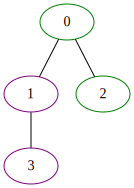

PASS
--------------------
testing


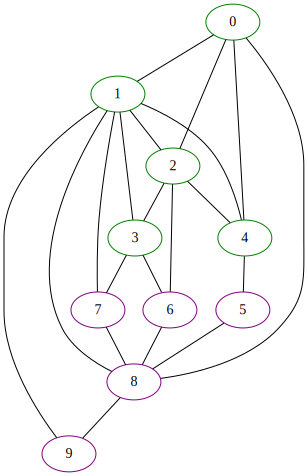

PASS
--------------------
testing


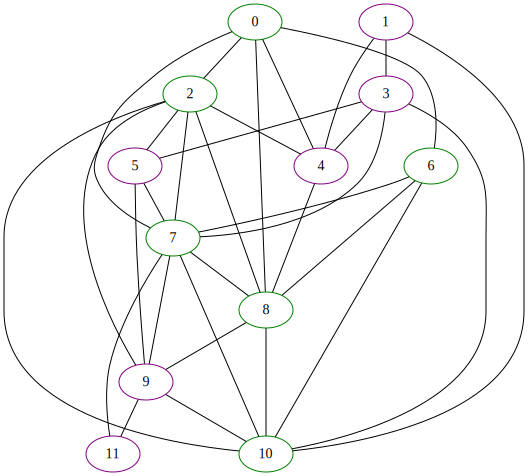

PASS


In [132]:
test()

In [135]:
def test_on_random_graphes():
    graph_params = [([n,n], .6, .2) for n in range(2,11)]
    for nv_subg, p_intra, p_inter in graph_params:
        input_graph = nx.random_partition_graph(nv_subg, p_intra, p_inter).edges()
        n_cuts_metis = part_on_metis(input_graph)
        n_cuts_isakov = part_on_isakov(input_graph)
        if n_cuts_isakov == n_cuts_metis:
            print nv_subg[0],'vertexes graph','PASS'
        else:
            print nv_subg[0],'vertexes graph', 'FAIL'
            print 'n_cuts_metis =',n_cuts_metis
            print 'n_cuts_isakov =',n_cuts_isakov
            print 'the graph is',input_graph

In [ ]:
test_on_random_graphes()

[(0, 1), (0, 2), (0, 4), (0, 7), (1, 2), (1, 7), (2, 3), (2, 4), (2, 7), (4, 5), (4, 6), (5, 7), (6, 7)]


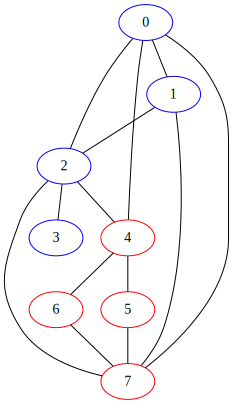

5


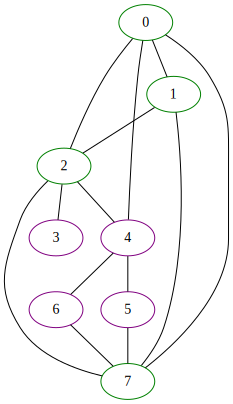

5


In [140]:
#input_graph = [(0, 1), (0, 2), (0, 4), (0, 6), (1, 3), (1, 4), (1, 6), (2, 9), (2, 3), (2, 5), (3, 8), (3, 4), (3, 6), (4, 5), (5, 9), (5, 6), (7, 8), (7, 9)]
input_graph = [(0, 1), (0, 3), (0, 4), (1, 2), (2, 3), (2, 5), (3, 4), (3, 5)]
input_graph = [(0, 1), (0, 2), (0, 3), (1, 4), (2, 3), (3, 4), (3, 5), (4, 5)]
input_graph = [(0, 1), (0, 2), (0, 3), (0, 7), (1, 2), (1, 3), (3, 5), (4, 5), (4, 6), (6, 7)]
input_graph = [(0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 5), (3, 5), (4, 5), (4, 6), (4, 7), (5, 6), (5, 7), (6, 7)]
input_graph = [(0,1),(1,3),(2,0)]
input_graph = nx.random_partition_graph([4,4], .7, .3).edges()
print input_graph
print part_on_metis(input_graph, plot_result=True)
print part_on_isakov(input_graph, plot_result=True)